# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [5]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './lab 2 data/train.p'
testing_file = './lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
# TODO: number of training examples
n_train = len(X_train)
n_train1=X_train.size
n_train2=X_train.shape
# TODO: number of testing examples
n_test = len(X_test)
n_test1=X_test.size
n_test2=X_test.shape
# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


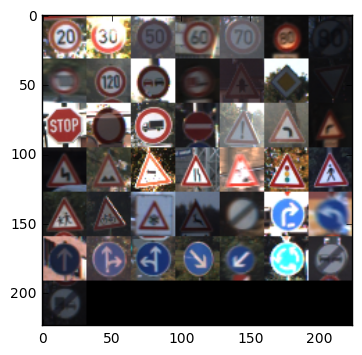

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed
def showimg(X_train):
    import matplotlib.pyplot as plt
    import numpy as np
    cols=int(np.sqrt(len(X_train)))
    rows=int(np.sqrt(len(X_train)))
    init=0
    for i in np.arange(cols):
        for j in np.arange(rows):
            if j==0:
                img=X_train[init+i*rows]
                continue
            img=np.column_stack((img,X_train[init+i*rows+j]))
        if i==0:
            img1=img
            continue
        img1=np.vstack((img1,img))

    plt.imshow(img1)


    #plt.plot(y_train)
    plt.show()
#show image of each class
import numpy as np
inputs=np.zeros((49,32,32,3),dtype=np.uint8)
for i in np.arange(43):
    a=np.where(y_train==(i))
    inputs[i]=X_train[a[0][50]]
    
showimg(inputs)

#also can show the entire data set 
#showimg(X_train)

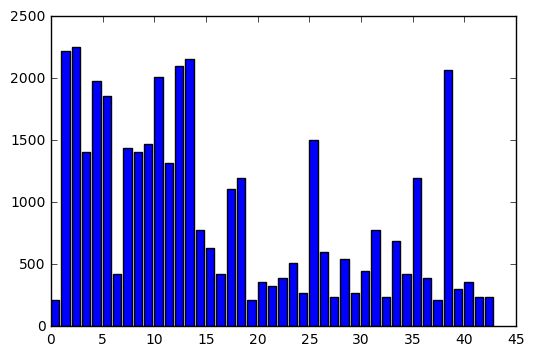

In [4]:
###show the number of samples in each class
import matplotlib.pyplot as plt
#plt.plot(y_train)
num=list()
for i in range(43):
    temp=np.where(y_train==i)
    num.append(len(temp[0]))
plt.bar(range(43),num)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import scipy.ndimage
import random
import numpy as np
from tqdm import tqdm

### Generate data additional by rotate([-15,+15] degrees) and shift ([-3,3] pixels)
def fakeimg(img):
    if random.randint(0,1):
        rotate=random.uniform(-15, 15)
        img1=scipy.ndimage.rotate(img,rotate,(1,0),False)
    else:
        shiftx=random.randint(-3,3)
        shifty=random.randint(-3,3)
        img1=scipy.ndimage.shift(img,[shiftx,shifty,0])
    return img1

features=np.zeros((150500,32,32,3),dtype=np.uint8)
labels=np.zeros((150500,1),dtype=np.uint8)
count=0
for i in tqdm(np.arange(43)):
    cla=np.where(y_train==i)
    claslen=len(cla[0])
    for j in cla[0]:
        features[count]=X_train[j]
        labels[count]=y_train[j]
        count=count+1
    for j in range(claslen,3500):
        k=random.randint(0,claslen-1)
        temp=X_train[cla[0][k]]
        temp=fakeimg(temp)
        features[count]=temp
        labels[count]=y_train[cla[0][k]]
        count=count+1
        



100%|██████████| 43/43 [02:29<00:00,  4.13s/it]


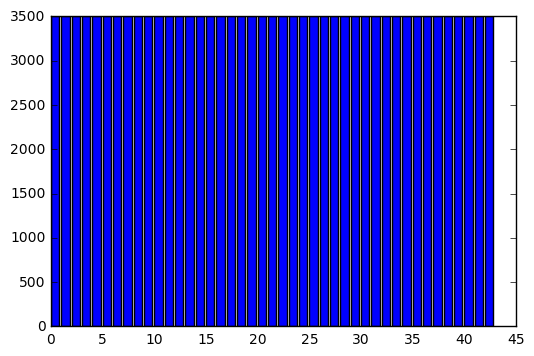

In [17]:
###show the number of each class after generate fake data
num1=list()
for i in range(43):
    temp=np.where(labels==i)
    num1.append(len(temp[0]))
plt.bar(range(43),num1)
plt.show()

In [18]:
#Normalize the image
def normalize_greyscale(image_data):
    a = -0.5
    b = 0.5
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )



In [19]:
features=np.array(features,dtype=np.float32)
features=normalize_greyscale(features)
X_test=np.array(X_test,dtype=np.float32)
X_test=normalize_greyscale(X_test)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

# apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(labels)
labels = encoder.transform(labels)
y_test = encoder.transform(y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1.Generate data additional by rotate([-15,+15] degrees) and shift ([-3,3] pixels)

2.Normalize the images data value to a range of -0.5-0.5

I normalized the input data to -0.5-0.5. According to the course,the values involved in the calculation fo the loss function get too big or too small will cause numeric issues. And, the values around a mean of zero and an equal variance will benifit to do optimization.

3.Apply One-Hot Encoding of the labels

4.The number of each input class is imbalance. So, I genrate more fake data in the small calss and less data in the big class. Finally, I get a data set that each class has 3500 examples.

In [20]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
train_features, valid_features, train_labels, valid_labels = train_test_split(
    features,
    labels,
    test_size=0.20,
    random_state=832289)



In [21]:
###The additional data generation progress is slow, so I add a check point here
import os
pickle_file = 'data1.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('data.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')


Saving data to pickle file...
Data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Shuffle the training data and split 20% as validation data. Actually, I don't know how many validation data I need to get a good model. But according to course, people tends to use more than 30000 examples. In this dataset, I get about 150000 examples. So I can get about 30000 examples to validation by a split of 20%.

I generated additional data. As the baseline paper said, ConvNets architectures have built-in invariance to small translations, scaling and rotations. This dataset does not naturally contain those deformations, adding them synthetically will yield more robust learning to potential deformations in the test set.

In [1]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
def inference(images,batch_size):
  with tf.variable_scope('conv1') as scope:
    weight1=tf.Variable(tf.truncated_normal([5,5,3,64],stddev=0.05,dtype=tf.float32,name='weights'))
    bias1=tf.Variable(tf.zeros(64),dtype=tf.float32,name='bias')
    #keep_prob=tf.placeholder(tf.float32)

    conv_layer1=tf.nn.conv2d(images,weight1,strides=[1,1,1,1],padding='SAME')
    conv_layer1=tf.nn.bias_add(conv_layer1,bias1)
    conv_layer1=tf.nn.relu(conv_layer1)
    #conv_layer1=tf.nn.dropout(conv_layer1,keep_prob)
    
  pool1=tf.nn.max_pool(conv_layer1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool1')
  
  with tf.variable_scope('conv2') as scope:
    weight2=tf.Variable(tf.truncated_normal([5,5,64,64],stddev=0.05,dtype=tf.float32,name='weights'))
    bias2=tf.Variable(tf.zeros(64),dtype=tf.float32,name='bias')
    conv_layer2=tf.nn.conv2d(pool1,weight2,strides=[1,1,1,1],padding='SAME')
    conv_layer2=tf.nn.bias_add(conv_layer2,bias2)
    conv_layer2=tf.nn.relu(conv_layer2)

  pool2=tf.nn.max_pool(conv_layer2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool2')
  
  lrn2 = tf.nn.lrn(pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='lrn2')

  with tf.variable_scope('fullconnect1') as scope:
    reshape=tf.reshape(lrn2,[batch_size,-1])
    dim=reshape.get_shape()[1].value
    weight3=tf.Variable(tf.truncated_normal([dim,384],stddev=0.04,dtype=tf.float32,name='weights'))
    bias3=tf.Variable(tf.zeros(384),dtype=tf.float32,name='bias')
    fullconnect1=tf.add(tf.matmul(reshape,weight3),bias3)
    fullconnect1=tf.nn.relu(fullconnect1)

  with tf.variable_scope('fullconnect2') as scope:
    weight4=tf.Variable(tf.truncated_normal([384,192],stddev=0.04,dtype=tf.float32,name='weights'))
    bias4=tf.Variable(tf.zeros(192),dtype=tf.float32,name='bias')
    fullconnect2=tf.add(tf.matmul(fullconnect1,weight4),bias4)
    fullconnect2=tf.nn.relu(fullconnect2)
  
  with tf.variable_scope('logits') as scope:
    weight5=tf.Variable(tf.truncated_normal([192,43],stddev=1/192,dtype=tf.float32,name='weights'))
    bias5=tf.Variable(tf.zeros(43),dtype=tf.float32,name='bias')
    logits=tf.add(tf.matmul(fullconnect2,weight5),bias5)

  return logits

def loss(logits,labels):
  labels = tf.cast(labels, tf.int32)
  cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits,labels, name='cross_entropy_per_example')
  cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
  return cross_entropy_mean

def train(loss,global_step):
  lr = tf.train.exponential_decay(0.1,
                                  global_step,
                                  10000,
                                  0.1,
                                  staircase=True)
  opt = tf.train.GradientDescentOptimizer(lr)
  opt=opt.minimize(loss)
  return opt

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I use a convolution neural network. 

The architecture is input -> conv1 -> pooling1 -> conv2 -> pooling2 -> lrn -> fullconnected1 -> fullconnected2 -> softmax. 
<img src="lab 2 data/conv.png" style="height: 75%;width: 75%; position: relative; right: 5%">
The input layer is the image, shape is (32,32,3). The first layer is a convolution layer, kernel size is (5,5,3,64) and stride is 1x1. After an activate layer using RELU, a max pooling layer is connected to the first layer. The pooling kernel is 3x3 and stride is 2x2, so the output of this max pooling layer is 16x16x64. Then repeat the operations above, another conv layer and max pooling layer is used. The conv kernel is (5,5,64,64) and the pooling stride is 2x2. So, the scale of output of these layers is 8x8x64. Here, I use a local response normalization to normalize the output. Next, the output is reshaped to a 4096 vector and fully connected to the first fullconnected layer which has 384 neurals. After a RELU activate, these 384 neurals are fully connected to the second fullconnected layer which has 198 neurals. And thes 198 neurals is fully connected to 43(the class num) neurals. Finally, the network will out put a vector has 43 elements. This vector will be used to calculate softmax cross entropy. 

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
from datetime import datetime
import os.path
import time

import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

from six.moves import xrange 
import random
#import _labFunc

batch_size=128
train_dir='/tmp/Lab2_train1'
MAXSTEP=200000
# Reload the data
pickle_file = 'data.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory
print('Data and modules loaded.')

def fill_feed_dict(images_p1,labels_p1):
  start=random.randint(0,len(train_features)-batch_size-1)
  images_seed=train_features[start:start+batch_size]
  labels_seed=train_labels[start:start+batch_size]
  feed_dict={images_p1:images_seed,
             labels_p1:labels_seed,
             }

  return feed_dict



if tf.gfile.Exists(train_dir):
    tf.gfile.DeleteRecursively(train_dir)
tf.gfile.MakeDirs(train_dir)
with tf.Graph().as_default():

    image_width=32
    image_height=32
    color_channels=3

    features=tf.placeholder(tf.float32,shape=[batch_size,image_width,image_height,color_channels])
    labels=tf.placeholder(tf.float32,shape=[batch_size,43])

    logits1 = inference(features,batch_size)

    # Calculate loss.
    loss1 = loss(logits1, labels)

    global_step = tf.Variable(0, trainable=False)

    
    is_correct_prediction = tf.equal(tf.argmax(logits1, 1), tf.argmax(labels, 1))
    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    opt = train(loss1, global_step)
    # Create a saver.
    saver = tf.train.Saver(tf.all_variables())

    init=tf.initialize_all_variables()        
    epochs=6
    with tf.Session() as session:
      session.run(init)
      batch_count = int(len(train_features)/batch_size)

      for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [opt, loss1],
                feed_dict={features: batch_features, labels: batch_labels})

        vaild_batch_count = int(len(valid_features)/batch_size)
        vailacc=list()
        for vaild_batch_i in xrange(vaild_batch_count):
            batch_start = vaild_batch_i*batch_size
            batch_features = valid_features[batch_start:batch_start + batch_size]
            batch_labels = valid_labels[batch_start:batch_start + batch_size]
            validation_accuracy = session.run(accuracy,feed_dict={features: batch_features, labels: batch_labels})
            vailacc.append(validation_accuracy)

        print("Validation accuracy: %f"%float(sum(vailacc)/len(vailacc)))
        
        checkpoint_path = os.path.join(train_dir, 'model.ckpt')
        saver.save(session, checkpoint_path, global_step=(epoch_i+1)*batch_count*batch_size)


Data and modules loaded.


Epoch  1/6: 100%|██████████| 940/940 [00:11<00:00, 80.19batches/s]


Validation accuracy: 0.901563


Epoch  2/6: 100%|██████████| 940/940 [00:11<00:00, 80.75batches/s]


Validation accuracy: 0.978391


Epoch  3/6: 100%|██████████| 940/940 [00:11<00:00, 80.18batches/s]


Validation accuracy: 0.985904


Epoch  4/6: 100%|██████████| 940/940 [00:11<00:00, 80.45batches/s]


Validation accuracy: 0.990492


Epoch  5/6: 100%|██████████| 940/940 [00:11<00:00, 79.58batches/s]


Validation accuracy: 0.995146


Epoch  6/6: 100%|██████████| 940/940 [00:11<00:00, 80.15batches/s]


Validation accuracy: 0.995745


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The optimizer is Gradient Descent Optimizer. 

The batch size is 128. 

I have denmonstrated some hyperparameters in question 3 such as the convolution kernel and stride size, max pooling kernel and stride size and so on. The learning rate is initialzed as 0.1 and decays every 10000 steps with a base of 0.1.

According to the reviews, in order to avoid overfitting, I print the validation accuracy every epoch when running the optimizer. Through my observation, I use 6 epochs. 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

In this problem, I choose convolutional neural network. 
The traffic sign has the  qualities that statistical invariants. It may located on different place of the image. But the traffic sign itself never change. 
As the course said, ConvNets architectures will be suit for this problem because of the weight sharing idea. 
Convnets will share their parameters across space. So, when the network meet a traffic sign, its learns waht about a traffic sign can be reused, and not relearn it.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

ClassId SignName
   
0 Speed limit (20km/h)
   
1 Speed limit (30km/h)
   
2 Speed limit (50km/h)
   
3 Speed limit (60km/h)
   
4 Speed limit (70km/h)
   
5 Speed limit (80km/h)
   
6 End of speed limit (80km/h)
   
7 Speed limit (100km/h)
   
8 Speed limit (120km/h)
   
9 No passing
   
10 No passing for vechiles over 3.5 metric tons
   
11 Right-of-way at the next intersection
   
12 Priority road
   
13 Yield
   
14 Stop
   
15 No vechiles
   
16 Vechiles over 3.5 metric tons prohibited
   
17 No entry
   
18 General caution
   
19 Dangerous curve to the left
   
20 Dangerous curve to the right
   
21 Double curve
   
22 Bumpy road
   
23 Slippery road
   
24 Road narrows on the right
   
25 Road work
   
26 Traffic signals
   
27 Pedestrians
   
28 Children crossing
   
29 Bicycles crossing
   
30 Beware of ice/snow
   
31 Wild animals crossing
   
32 End of all speed and passing limits
   
33 Turn right ahead
   
34 Turn left ahead
   
35 Ahead only
   
36 Go straight or right
  

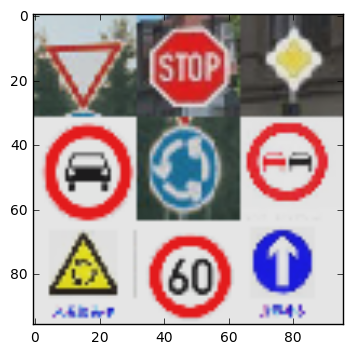

In [1]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import _labFunc
import csv

def showimg(X_train):
    import matplotlib.pyplot as plt
    import numpy as np
    cols=int(np.sqrt(len(X_train)))
    rows=int(np.sqrt(len(X_train)))
    init=0
    for i in np.arange(cols):
        for j in np.arange(rows):
            if j==0:
                img=X_train[init+i*rows]
                continue
            img=np.column_stack((img,X_train[init+i*rows+j]))
        if i==0:
            img1=img
            continue
        img1=np.vstack((img1,img))

    plt.imshow(img1)
    #plt.plot(y_train)
    plt.show()
    
def normalize(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 1
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )


batch_size=10

d=dict()
for line in open("signnames.csv"):
     num,name = line.split(",")
     d[num]=name
     print(num,name,"  ",)

# read 10 images as input and resize to 32x32
images=np.zeros((10,32,32,3),dtype=np.float32)
for i in range(10):
    img=plt.imread("./lab 2 data/_"+str(i)+".png")
    img.resize(32,32,3)
    images[i]=img

images=normalize(images)

showimg(images)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In this classifier, input images must be resized to 32x32 pixels. Usually, signs take only a small part of the picture. If I resize the whole image, it isn't a traffic sign. So I cropped the traffic signs from the picture, and use them as input.

Thanks to the review, I think some qualities will make classification diffcult, such as light condition, the size of sign and the orientation of the sign. If these qualities changes a lot, it will be diffcult to make correct classifications. But ConvNets architectures have built-in invariance to small translations, scaling and rotations. So the classifier is not sensitive to small change of these qualities. Such as the fifth image "Roundabout mandatory" is slightly oriente to the left and the eighth image "speed limit 60km/h" is larger than others. And the classifier have made the correct classification to both of them.

In [2]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
image_width=32
image_height=32
color_channels=3


features=tf.placeholder(tf.float32,shape=[batch_size,image_width,image_height,color_channels])
labels=tf.placeholder(tf.float32,shape=[batch_size,43])

init=tf.initialize_all_variables()


predict = _labFunc.inference(features,batch_size)

logits = tf.nn.softmax(predict)

top_k_op = tf.nn.top_k(logits, 5)

saver = tf.train.Saver()

with tf.Session() as session:
    ckpt = tf.train.get_checkpoint_state('/tmp/Lab2_train1')
    if ckpt and ckpt.model_checkpoint_path:
      # Restores from checkpoint
      saver.restore(session, ckpt.model_checkpoint_path)
      # Assuming model_checkpoint_path looks something like:
      #   /my-favorite-path/cifar10_train/model.ckpt-0,
      # extract global_step from it.
      global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
    else:
      print('No checkpoint file found')
    
    session.run(init)
    
    res = session.run(
        [top_k_op],
        feed_dict={features: images})




### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

If the input image is resized to 32x32 and the main part is traffic sign, I think this model will work. And it performs well in the images I found and cropped. 

I choose 10 images here, 6 of which are German traffic sign and belond to the classes we have trained. The classification result is all the 6 images are classified correct. And the other 4 of them are local traffic sign and we nerver trained. The classification result is interesting. 

Maybe 10 images are too small to telling. But from these 10 images, we can see that this classifier has a same performance on the web images and the test set. It works well on the web images. 

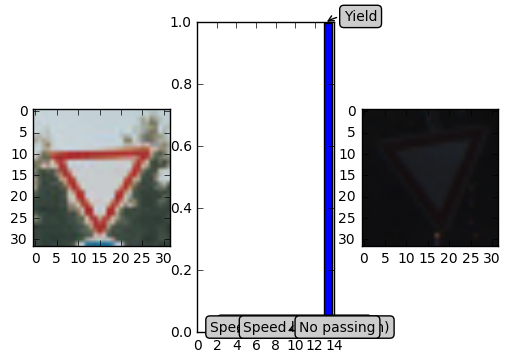

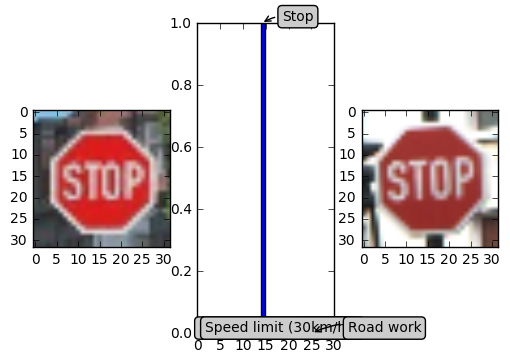

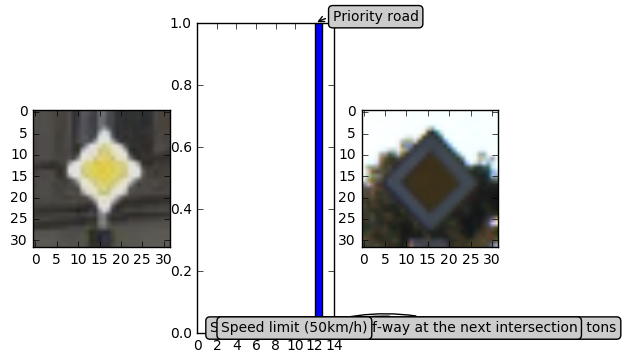

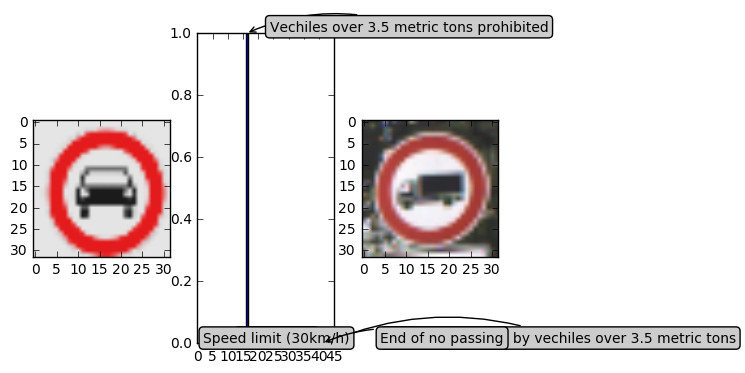

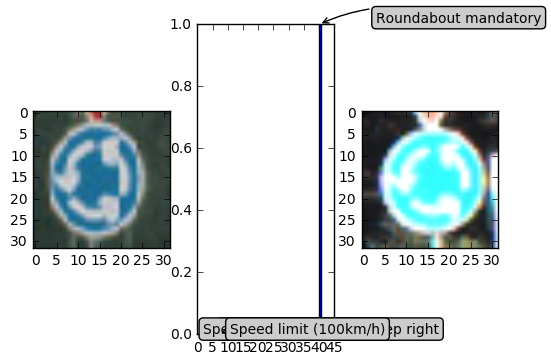

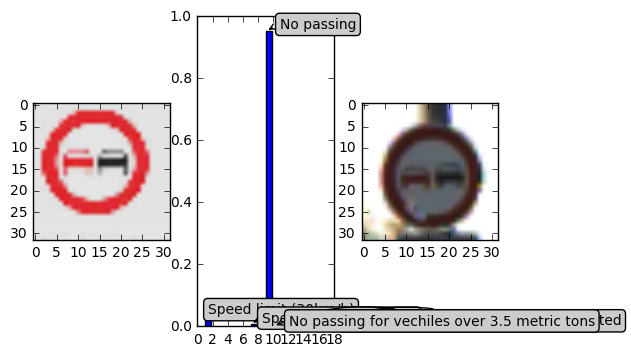

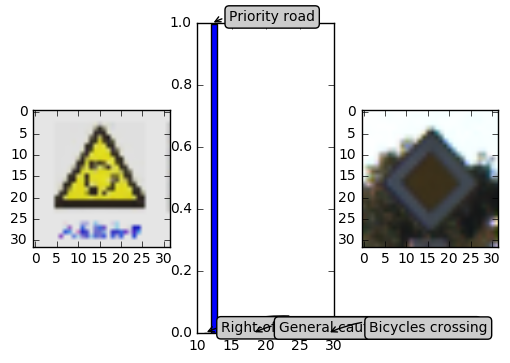

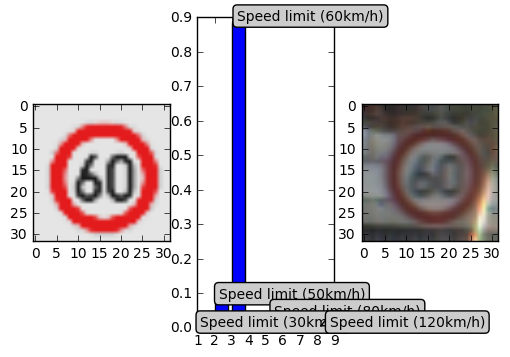

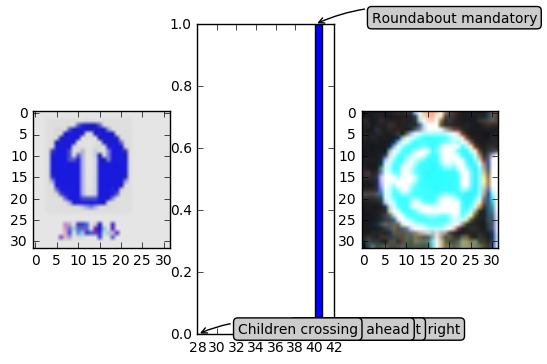

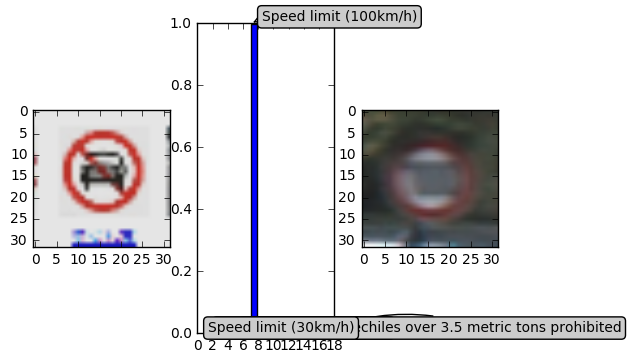

In [10]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
for i in range(10):
    plt.subplot(131)
    plt.imshow(images[i])
    plt.subplot(132)
    plt.bar(left=res[0][1][i],height=res[0][0][i])
    for j in range(len(res[0][1][i])):
        ss=d[str(res[0][1][i][j])][:-1]
        p1=(res[0][1][i][j],res[0][0][i][j])
        p2=(res[0][1][i][j]+1,res[0][0][i][j]+1)
        plt.annotate(ss,xy=p1,xytext=p2,
            textcoords='offset points',
            bbox=dict(boxstyle="round",fc="0.8"),
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"),
            )
    plt.subplot(133)
    plt.imshow(inputs[res[0][1][i][0]])
    plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

As is shown above. The left side is the input image I found on the web. The middle histogram is the top five prediction. In the histogram,y aixs is the softmax probabilities value and x aixs is the calss number. In addition, I annotated the calss name  on the top of each bar. 

In this step, I find these pictures from the Internet. The classifier cannot recognize some signs which did not appeared in the train data, but it proved interesting predictions.

I will explain each image below:
1. The top 3 predictions of the first image are 'yeild','speed limit (59km/h)' and 'speed limit (30km/h)'. Of course, the top 1 prediction is a correct prediction. And I think is certain prediction, because the probabilitie is almost 100%.
2. The second image has a prediction 'Stop'. The top 1 probabilitie is much highter than others. It is a correct and certain prediction. 
3. The third image has a prediction'priority road'. Similary to the second image, I think this prediction is correct and certain.
4. The top 3 predictions of the fourth image are 'Vechiles over 3.5 metric tons prohibited', 'no pass', 'end of passing by vechiles over 3.5 metric tons'. This is an incorrect prediction. This image never appeared in our train set, so on correct prediction existence. Look at the right image, they do have some similarity.
5. The top 1 prediciton is 'Roundabout mandatory', and it much higher than the others. I think it is a correct and certain prediction.
6. The top 1 prediction of the sixth image is 'no passing'. It is correct. The prediction has a probabilite is 95%. I think this is a certain prediction.
7. The seventh image is a Chinese traffic sign means "cautious roundabout". Maybe the color and shape, 'Priority road' get the highest probabilitie.
8. The eighth image has an correct top 1 prediction, 'speed limit (60 km/h)'. And the probability value is about 90%, I think it is a certain prediction. 
9. The top one prediction of the ninth image is 'roundabout mandatory'. I'm a little confused that the 35th calss 'ahead only' should be more fit this image, but it does not even appear in the top 5.
10. To image 10, the classifier made a certain prediction, 'Speed limit (100 km/h). Of course, it is incorrect. This sign isn't belong to our tarin set. And we can see that, all of the top 5 signs has a black pattern in a red circle. 



### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.